Code inspiration for Stumpf Log-Ratio SDB taken from [here](https://github.com/balajiceg/NearShoreBathymetryPlugin/blob/master/process.py).

In [4]:
import sys
import eolearn
from eolearn.core import (
    FeatureType,
    MergeEOPatchesTask,
    EONode,
    linearly_connect_tasks,
    EOWorkflow,
    OutputTask,
    EOTask
)
from eolearn.core.eoworkflow_tasks import InputTask
from eolearn.io import ImportFromTiffTask
from eolearn.ml_tools import TrainTestSplitTask

import os
import glob
import datetime

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx

In [3]:
sentinel_archives_root = '../data/sentinel'
sentinel_archives_pattern = f'{sentinel_archives_root}/*.SAFE'
sentinel_archives = glob.glob(sentinel_archives_pattern)
l2a_products = eolx.io.get_products_by_level(sentinel_archives, 'L2A')
l2a_products

[(datetime.datetime(2021, 11, 25, 17, 16, 41),
  '../data/sentinel\\S2A_MSIL2A_20211125T171641_N9999_R112_T15TVM_20220314T174330.SAFE')]

In [11]:
import_millie_lacs = ImportFromTiffTask((FeatureType.DATA_TIMELESS, 'bathy_data'), '../data/mille_lacs.tiff')
reproject_bathy = eolx.raster.ReprojectRasterTask(
    (FeatureType.DATA_TIMELESS, 'bathy_data'),
    target_resolution=(10, 10),
)
append_bathy_data_mask = eolx.bathybase.AppendBathyTimelessDataMask((FeatureType.DATA_TIMELESS, 'bathy_data'), band_index=0)

output_label = 'millie_lacs_eop'
nodes = linearly_connect_tasks(
    import_millie_lacs,
    reproject_bathy,
    append_bathy_data_mask,
    OutputTask('millie_lacs_eop')
)
workflow = EOWorkflow(nodes)

worfklow_result = workflow.execute()
millie_lacs_eop = worfklow_result.outputs[output_label]

height, width, _ = millie_lacs_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')].shape
l2a_eopatch = eolx.io.construct_eopatch_from_sentinel_archive(l2a_products[0][1], target_shape=(height, width), bbox=millie_lacs_eop.bbox)

merge_patches_task = MergeEOPatchesTask()
merged_eop = merge_patches_task.execute(millie_lacs_eop, l2a_eopatch)

data_feature = (FeatureType.MASK_TIMELESS, 'bathy_data_mask')
train_test_mask_feature = (FeatureType.MASK_TIMELESS, 'train_test_split')

train_test_split_task = TrainTestSplitTask(
    input_feature=data_feature,
    output_feature=train_test_mask_feature,
    bins=[0.8],
    split_type=eolearn.ml_tools.train_test_split.TrainTestSplitType.PER_PIXEL,
)

valid_train_test_data_mask_task = eolx.ml_util.AddValidTrainTestMasks(
    train_test_maks_feature=train_test_mask_feature,
    valid_data_mask_feature=data_feature
)

input_task = InputTask(merged_eop)
input_node = EONode(input_task, inputs=tuple())

train_test_split_node = EONode(train_test_split_task, inputs=[input_node])
valid_train_test_data_mask_node = EONode(valid_train_test_data_mask_task, inputs=[train_test_split_node])

tt_wf_output_label = 'tt_wf_output'
output_task = OutputTask(tt_wf_output_label)
output_node = EONode(output_task, inputs=[valid_train_test_data_mask_node])

train_test_wf = EOWorkflow(
    [
        input_node,
        train_test_split_node,
        valid_train_test_data_mask_node,
        output_node
    ]
)

tt_wf_res = train_test_wf.execute(
    input_kwargs={
        train_test_split_node: {'seed': 42}
    }
)

train_test_eop = tt_wf_res.outputs[tt_wf_output_label]
train_test_eop

EOPatch(
  data={
    L2A_data: numpy.ndarray(shape=(1, 2871, 2794, 12), dtype=uint16)
  }
  data_timeless={
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
    test_split_valid: numpy.ndarray(shape=(2871, 2794, 1), dtype=int32)
    train_split_valid: numpy.ndarray(shape=(2871, 2794, 1), dtype=int64)
    train_test_split: numpy.ndarray(shape=(2871, 2794, 1), dtype=int64)
  }
  meta_info={
    mission: 'S2A'
    test_count: 1039055
    test_perc: 0.19988842237900803
    train_count: 4159120
    train_perc: 0.8001115776209919
  }
  bbox=BBox(((436481.4788999969, 5106398.035399999), (464421.4788999969, 5135108.035399999)), crs=CRS('26915'))
  timestamp=[datetime.datetime(2021, 11, 25, 17, 16, 41)]
)

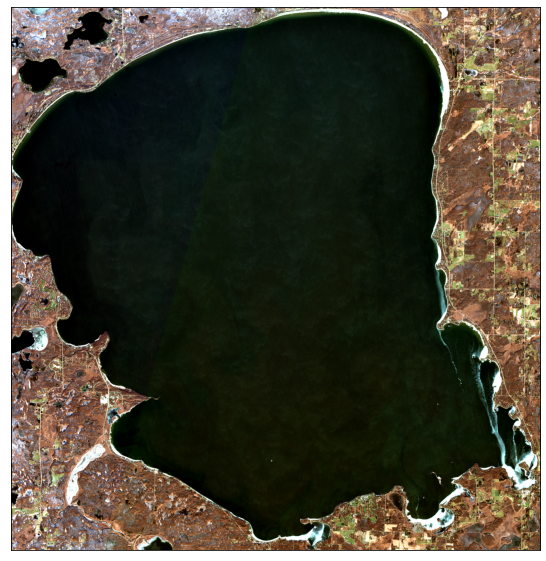

In [13]:
eolx.visualization.plot_eopatch(
    train_test_eop,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, "L2A_data"),
    stretch=True
)
plt.show()

In [48]:
train_mask_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')], axis=-1)


def get_stumpf_log_ratio(eopatch, feature, data_mask):
    # apply very small bias to not divide by zero
    eps_bias = 0.0000000000001
    blue_band = eopatch[feature][0,:,:,1][data_mask == 1] + eps_bias
    green_band = eopatch[feature][0,:,:,2][data_mask == 1] + eps_bias

    # in stumpf log-ratio the factor n is present to make sure that band values cannot be negative
    n = 10000
    # in stumpf log-ratio this would correspond to z (or rel_z) before applying the constant factor c and the intercept m_0
    # we can get to these values by fitting a linear regression
    X = np.log(n * blue_band) / np.log(n * green_band)
    X = X.reshape(-1, 1)

    return X


X = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, 'L2A_data'), train_mask_single_band)

y = train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')][train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')] == 1]
X.shape, y.shape

((4159120, 1), (4159120,))

In [49]:
from sklearn.linear_model import SGDRegressor

reg = SGDRegressor(max_iter=10000, tol=1e-3)
reg.fit(X, y)

SGDRegressor(max_iter=10000)

In [50]:
score = reg.score(X, y)
score

0.038240632717582934

In [51]:
from sklearn.metrics import mean_absolute_error

ypred = reg.predict(X)
mean_absolute_error(y, ypred)

7.05462031503108

In [53]:
mask_complete_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')], axis=-1)

X_all = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, 'L2A_data'), mask_complete_single_band)

y_hat_all = reg.predict(X_all)
empty_validation_target = np.zeros(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')].shape)
empty_validation_target[train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1] = y_hat_all

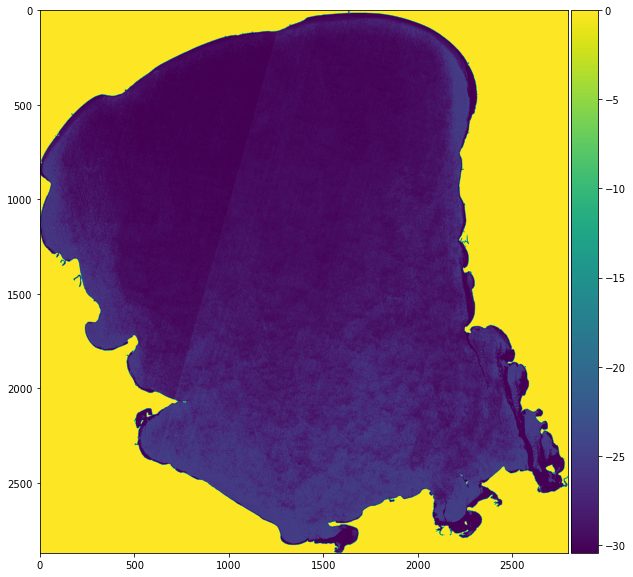

In [54]:
eolx.visualization.plot_ndarray_band(empty_validation_target, cmap='viridis')
plt.show()

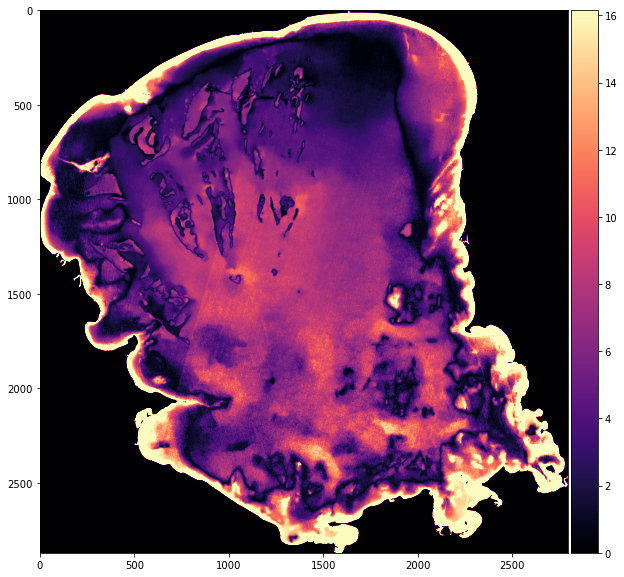

In [56]:
eolx.visualization.plot_ndarray_band(np.abs(empty_validation_target - train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')]), cmap='magma')
plt.show()